In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp

from uncertainties import ufloat
from uncertainties.umath import log
from uncertainties import unumpy
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

nsamples = 10000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

alpha=0.5
f, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].scatter(dust2, dust_index, c='k', alpha=0.5)
ax[1].scatter(dust1, dust2, c='k', alpha=0.5)
ax[2].scatter(recent_sfrs, dust2, c='k', alpha=0.5)

train_sfrs = torch.from_numpy(recent_sfrs)
train_dust2 = torch.from_numpy(dust2)
test_sfrs = torch.linspace(-5, 3, 100)
model, likelihood = create_gp_model([3.0, 15.0], train_sfrs, train_dust2)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence(f_preds, test_sfrs, train_sfrs, train_dust2, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    #arr = unumpy.uarray(f_preds.mean.numpy(), f_preds.stddev.numpy())
    #arr = unumpy.exp(arr)
    #means = unumpy.nominal_values(arr)
    #stds = unumpy.std_devs(arr)
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_sfrs, means, stds)
plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

train_dust2 = torch.from_numpy(dust2)
train_dust_index = torch.from_numpy(dust_index)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust_index)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust_index, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

train_dust2 = torch.from_numpy(dust2)
train_dust1 = torch.from_numpy(dust1)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust1)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust1, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

d2 = np.linspace(0.1,4.0,50)
dobj = DustAttnCalc()
d1sim, _ = dobj.get_d1(d2)
d1, d1e = np.average(d1sim, axis=0), np.std(d1sim, axis=0)
print("d1 values:", d1)
print("d1e values:", d1e)

plt.errorbar(d2, d1, d1e)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

In [2]:
ngal = 20000
n, tau, tau1, ne, taue, tau1e, sfr = gpdp.get_nagaraj22_samples(ngal)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

mean: 0.0531544425504665 std: 0.006128630965280335
[-1.97916667 -1.77083333 -1.5625     -1.35416667 -1.14583333 -0.9375
 -0.72916667 -0.52083333 -0.3125     -0.10416667  0.10416667  0.3125
  0.52083333  0.72916667  0.9375      1.14583333  1.35416667  1.5625
  1.77083333  1.97916667  2.1875    ] [0.58927353 0.58045461 0.58048741 0.56920244 0.56995093 0.55971575
 0.56428081 0.54864514 0.55939282 0.55167343 0.60144627 0.63226041
 0.69473496 0.74819567 0.79505565 0.84736043 0.90439611 0.96221153
 1.00526862 1.05590978 1.08977193] [0.12971979 0.12629878 0.13229521 0.13388881 0.14187756 0.14640496
 0.15202538 0.15372102 0.16444886 0.16728071 0.18165676 0.20633074
 0.21171685 0.17331784 0.14979049 0.13063571 0.12142812 0.12249174
 0.1150915  0.1196342  0.13104111]


<ErrorbarContainer object of 3 artists>

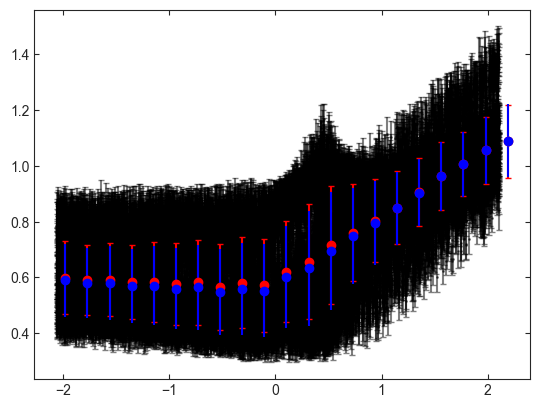

In [3]:
print("mean:", np.mean(taue), "std:", np.std(taue))
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -2.5, 2.5, 25)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

x, y, yerr = gpdp.process_samples_modified(sfr, tau, taue, -2.5, 2.5, 25)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

In [4]:
nsamples = 500000
recent_sfrs, dust2, dust_index, dust1 = gpdp.get_pop_cosmos_samples(nsamples)

<ErrorbarContainer object of 3 artists>

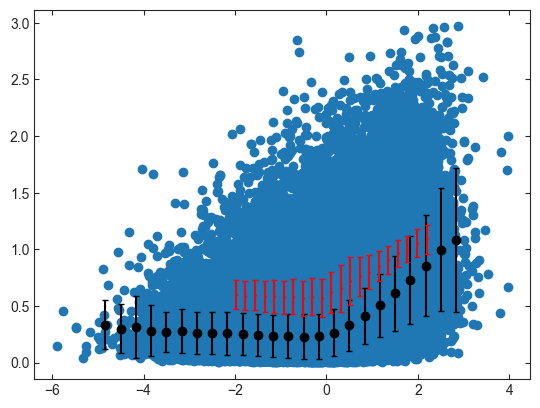

In [5]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 25)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

0.7886501364706743
0.7870337804050873
0.7855061882022186
0.7840947133716317
0.7828304301255523
0.7817471979617325
0.7808793694908663
0.780257269264207
0.7798995086941234
0.7798020385172444
0.7799267397501763
0.7801973064869462
0.7805120039808853
0.7807730379733894
0.7809159586473107
0.7809213650831383
0.7808075220026743
0.7806143756747398
0.780388237166895
0.78017081296019
0.7799928314480673
0.7798714726303442
0.7798107199606362
0.7798037867398033
0.7798367397282608
0.7798924382645092
0.7799540344848807
0.7800075472922059
0.7800433411493194
0.7800566004838014
0.7800470309041287
0.780018046029631
0.7799756594511719
0.7799272446642075
0.7798802844857936
0.779841217448267
0.7798144965363769
0.7798019870582148
0.7798028197363097
0.7798137593440546
0.7798300434757136
0.779846516271084
0.7798587813885322
0.7798640810835067
0.7798616927009121
0.7798527880393389
0.7798398603365848
0.7798259288043365
0.7798137552771651
0.7798052609539032
0.779801243901542
0.7798014042106988
0.7798046097275566
0

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


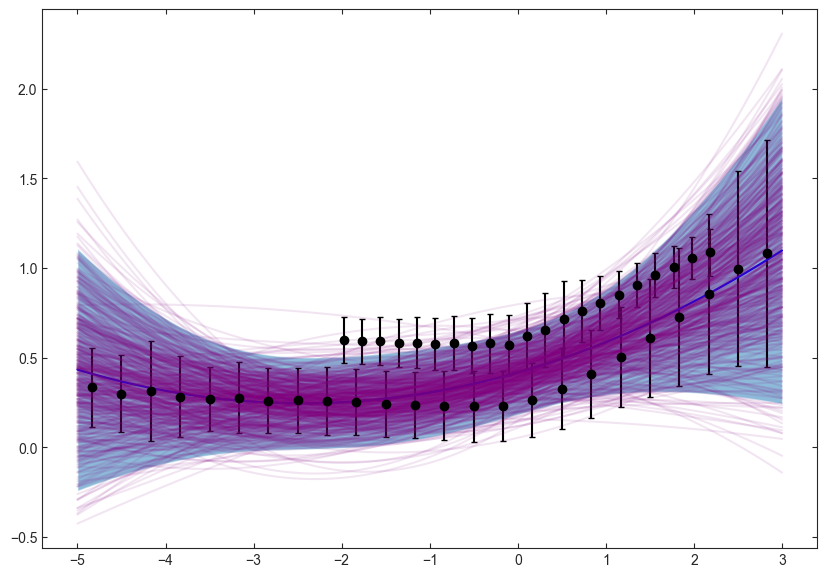

In [6]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

test_sfrs = torch.linspace(-5, 3, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_power(train_sfrs, train_dust2, train_dust2, power=2, lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2, train_dust2_errs, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

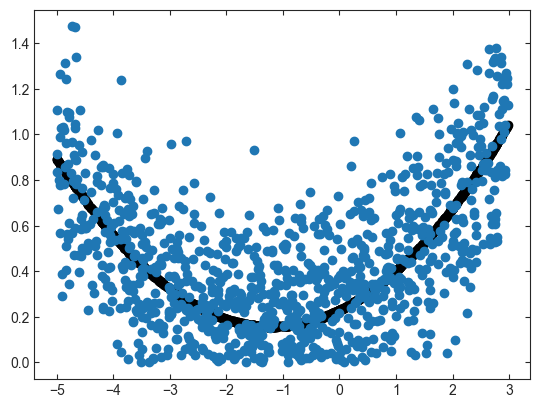

In [7]:
test_sfrs = torch.from_numpy(np.random.uniform(-5, 3, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_sfrs)
mean_dust2 = f_preds.sample().numpy()
scatter = np.random.uniform(0.1, 0.5)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [8]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

mean: 0.042890297087365976 std: 0.004517734019999767


<ErrorbarContainer object of 3 artists>

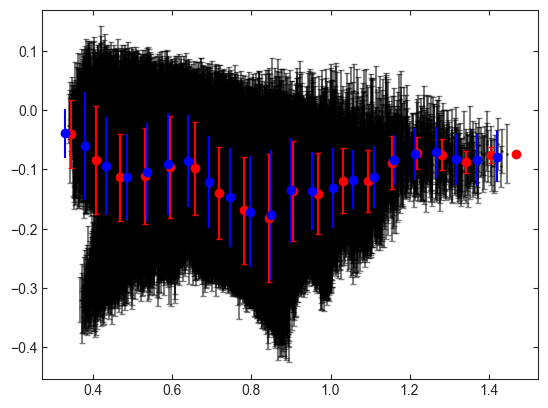

In [9]:
print("mean:", np.mean(ne), "std:", np.std(ne))

bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, 0, 1.5, 25)

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

x, y, yerr = gpdp.process_samples_modified(tau, n, ne, 0.25, 1.5, 25)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

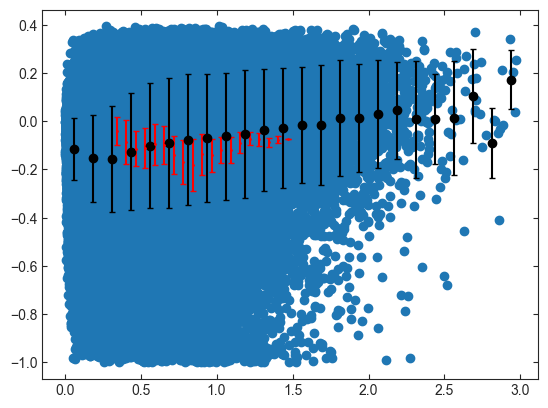

In [10]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

185.72233055109274
171.4373615322083
157.0690989136854
142.71039713494628
128.4627846579755
114.43551972531753
100.74423526232961
87.50913206383512
74.85267938906523
62.896793423285395
51.759482214965146
41.5509684725925
32.36933475100261
24.29578673784715
17.389704790880064
11.683753593340693
7.179441595576629
3.843652250752331
1.6067779670472462
0.3631263343419505
-0.025824132196207508
-0.02814987871508092
-0.03020203057581938
-0.0321137926705821
-0.03390144698663532
-0.03557837237861411
-0.03715564452761222
-0.03864251056520334
-0.04004676196962927
-0.04137502621212718
-0.04263299433990265
-0.04382559853161097
-0.04495715085627299
-0.04603145209105648
-0.04705187750790668
-0.04802144498081046
-0.048942869535466185
-0.04981860750128867
-0.05065089267816771
-0.051441766351910514
-0.05219310254609626
-0.052906629554980544
-0.05358394853917734
-0.05422654976520151
-0.05483582691763752
-0.055413089797811246
-0.05595957563697649
-0.0564764591885864
-0.0569648617181457
-0.057425858976458
-

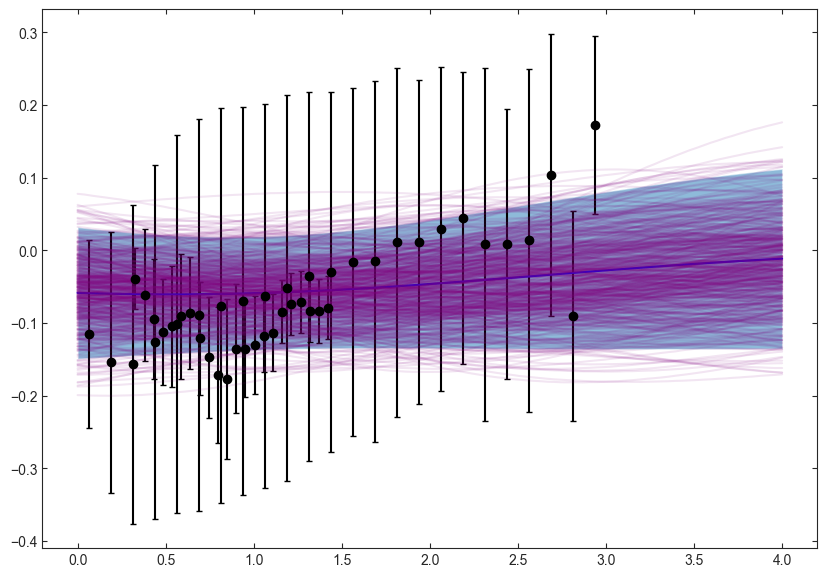

In [11]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model(train_dust2, train_dust_index, train_dust_index_errs, [2.0, 6.0], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

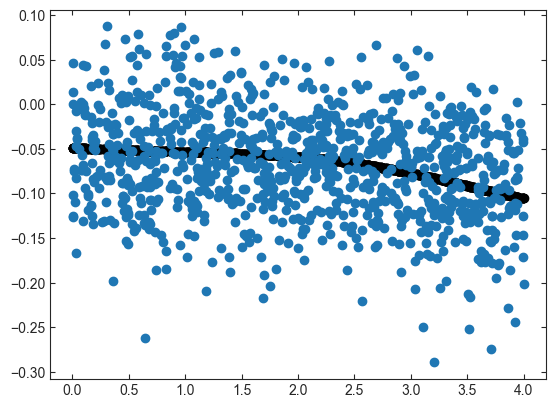

In [12]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [13]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

mean: 0.059651216128809144 std: 0.010685554862994405


<ErrorbarContainer object of 3 artists>

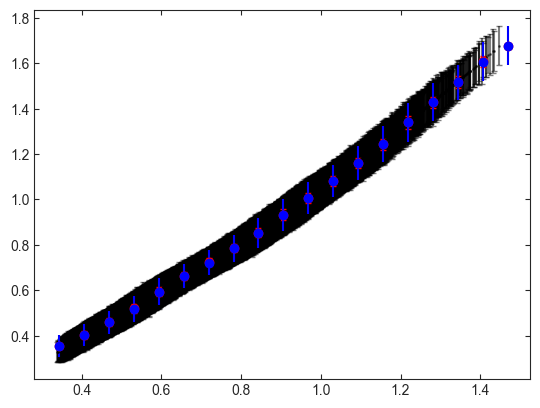

In [14]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)

print("mean:", np.mean(tau1e), "std:", np.std(tau1e))
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, 0.0, 1.5, 25)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, 0.0, 1.5, 25)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

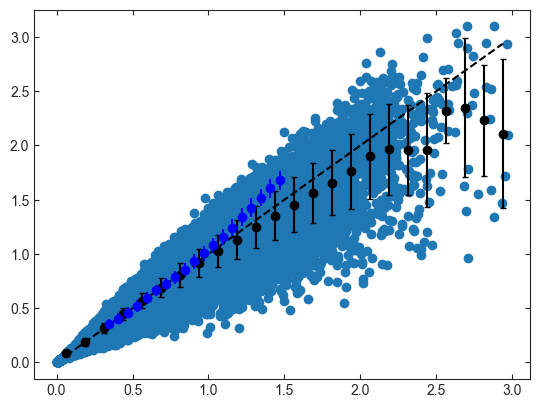

In [15]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')
plt.errorbar(x, y, yerr, fmt='bo')

1271.7396354651453
1232.620415650253
1192.2266497073942
1150.6463128272862
1107.98152717864
1064.3483398115848
1019.876212510141
974.7072051473656
928.9948501909582
882.9027305457165
836.6027851807767
790.2733782709537
744.0971778413518
698.2588978749507
652.9429623591692
608.3311505448218
564.6002803764203
521.9199825825075
480.45061207832896
440.3413365962666
401.728435118929
364.7338310657614
329.4638776700665
296.00840597554793
264.4400396848881
234.8137758693619
207.16682631552354
181.5187109472441
157.87159215153966
136.2108367538897
116.50579062849893
98.7107493063026
82.7661063109675
68.59965921414965
56.128051518499106
45.25832647526367
35.88956690705588
27.914593170287485
21.221689727622785
15.696329598891463
11.222865407464054
7.6861560026635605
4.973098838100173
2.974040481499678
1.5840408135848763
0.7039705577716964
0.24142661512945385
0.11126266703982018
0.11129244318098974
0.11129049993610458
0.11126237790088575
0.11121286764591697
0.11114608667026922
0.11106555505092794

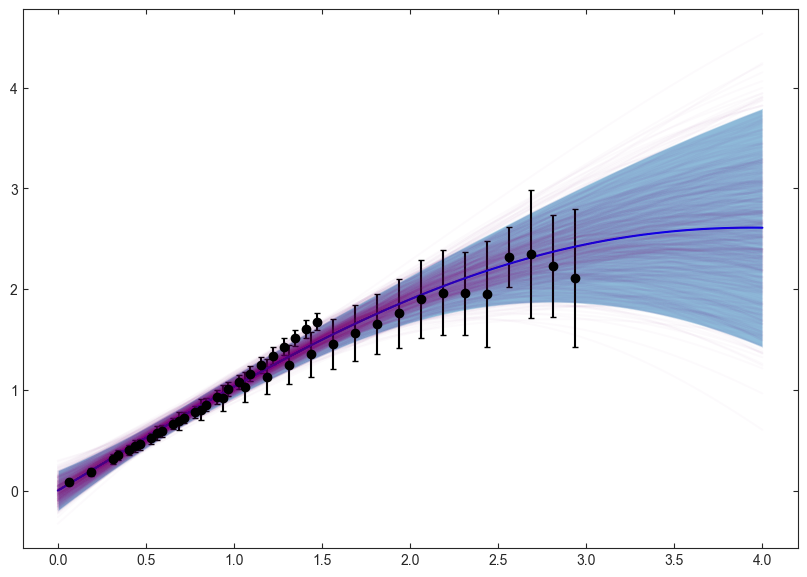

In [16]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model(train_dust2, train_dust1, train_dust1_errs, [4.0, 10.0], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.02)

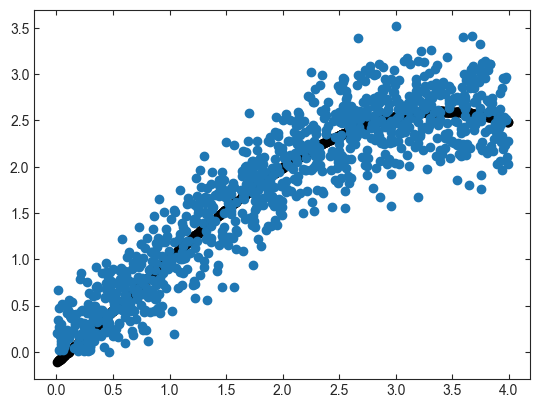

In [17]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust1 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, scatter, 0.0, 4.0, len(test_tau)))

In [18]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')